In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import multiprocessing

@torch.no_grad()
def gather_feats_targets(model, dataloader, device):
    features = []
    targets = []

    model.eval()
    for idx, (feat, target) in enumerate(dataloader):
        if len(feat.shape) > 2:
            feat = feat[:, 0, :]
        feat = feat.to(device)
        target = target.to(device)
        out_feat, out_target= model(feat, target)
        features.append(out_feat)
        targets.append(target[:, 0])
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(targets, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_feats_targets(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_feats_targets(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [5]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [6]:
def standardize_dataset(dataset):
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    features_std[features_std == 0] = 1
    standardized_features_list = []
    
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [7]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [8]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()
    

In [9]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2
num_epochs = 100

lr = 0.01 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [10]:
sites = pd.read_csv("participants.csv")["dataset"].unique()

Epoch 0 | Mean Loss 5.205772770775689
Epoch 1 | Mean Loss 4.4758960494288695
Epoch 2 | Mean Loss 4.052222357855903
Epoch 3 | Mean Loss 3.344844244144581
Epoch 4 | Mean Loss 2.9625255443431713
Epoch 5 | Mean Loss 2.8834713300069175
Epoch 6 | Mean Loss 2.8713132010565863
Epoch 7 | Mean Loss 2.869191611254657
Epoch 8 | Mean Loss 2.8700338469611273
Epoch 9 | Mean Loss 2.8679773719222457
Epoch 10 | Mean Loss 2.866706477271186
Epoch 11 | Mean Loss 2.8665540836475514
Epoch 12 | Mean Loss 2.865142901738485
Epoch 13 | Mean Loss 2.8650414678785534
Epoch 14 | Mean Loss 2.8642575917420565
Epoch 15 | Mean Loss 2.862764314368919
Epoch 16 | Mean Loss 2.8617188135782876
Epoch 17 | Mean Loss 2.8603005232634366
Epoch 18 | Mean Loss 2.858629747673317
Epoch 19 | Mean Loss 2.8561541769239636
Epoch 20 | Mean Loss 2.852358270574499
Epoch 21 | Mean Loss 2.8474437484034785
Epoch 22 | Mean Loss 2.8367513992168285
Epoch 23 | Mean Loss 2.8162908024258084
Epoch 24 | Mean Loss 2.720304091771444
Epoch 25 | Mean Loss

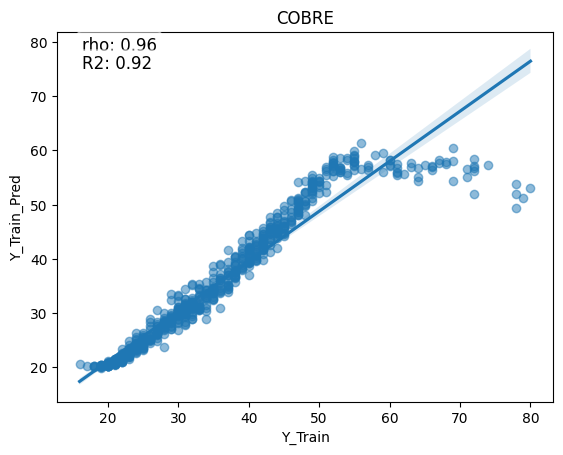

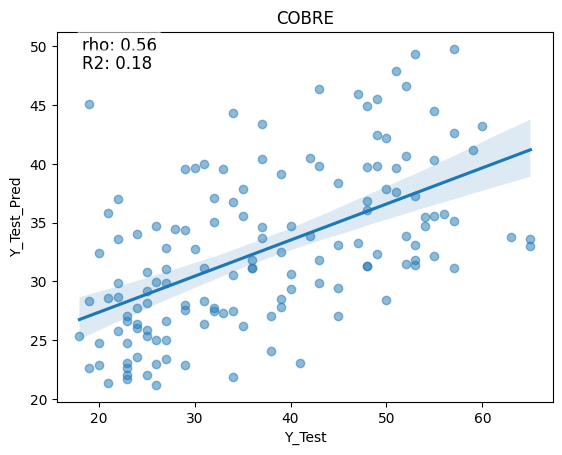

Epoch 0 | Mean Loss 5.2724086355279995
Epoch 1 | Mean Loss 3.7903821998172336
Epoch 2 | Mean Loss 3.1557728670261525
Epoch 3 | Mean Loss 2.9099051466694585
Epoch 4 | Mean Loss 2.8527224637843944
Epoch 5 | Mean Loss 2.8427124155892267
Epoch 6 | Mean Loss 2.8374507868731462
Epoch 7 | Mean Loss 2.835987616468359
Epoch 8 | Mean Loss 2.8328643198366517
Epoch 9 | Mean Loss 2.830315015934132
Epoch 10 | Mean Loss 2.8262297489024975
Epoch 11 | Mean Loss 2.818641834788852
Epoch 12 | Mean Loss 2.806611758691293
Epoch 13 | Mean Loss 2.772611286905077
Epoch 14 | Mean Loss 2.6291930189839117
Epoch 15 | Mean Loss 2.576734834247165
Epoch 16 | Mean Loss 2.581321398417155
Epoch 17 | Mean Loss 2.5701967389495284
Epoch 18 | Mean Loss 2.570623349260401
Epoch 19 | Mean Loss 2.5650699138641357
Epoch 20 | Mean Loss 2.5570425236666643
Epoch 21 | Mean Loss 2.5559808104126542
Epoch 22 | Mean Loss 2.5551244108765214
Epoch 23 | Mean Loss 2.5665155251820884
Epoch 24 | Mean Loss 2.557551066080729
Epoch 25 | Mean Los

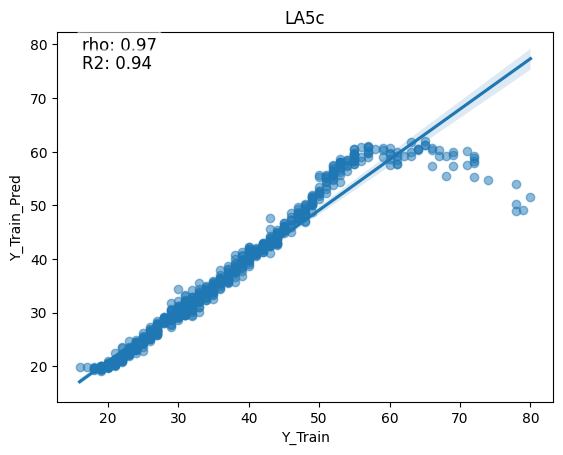

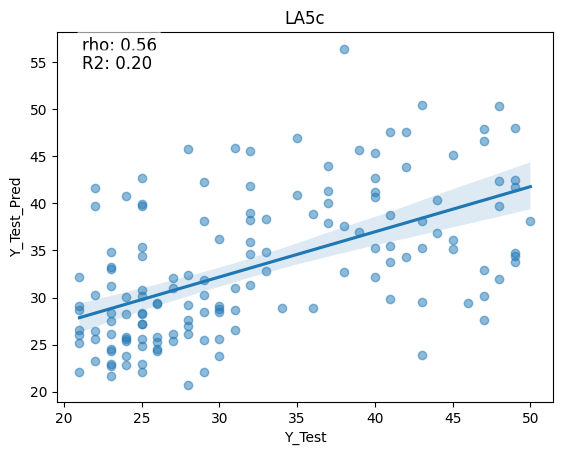

Epoch 0 | Mean Loss 3.3429731173174724
Epoch 1 | Mean Loss 2.8337953771863664
Epoch 2 | Mean Loss 2.8250270060130527
Epoch 3 | Mean Loss 2.822554873568671
Epoch 4 | Mean Loss 2.819445048059736
Epoch 5 | Mean Loss 2.814707168510982
Epoch 6 | Mean Loss 2.803654440811702
Epoch 7 | Mean Loss 2.7475929728576114
Epoch 8 | Mean Loss 2.5738120462213243
Epoch 9 | Mean Loss 2.5666673949786594
Epoch 10 | Mean Loss 2.57431332554136
Epoch 11 | Mean Loss 2.578206241130829
Epoch 12 | Mean Loss 2.595754223210471
Epoch 13 | Mean Loss 2.573954795088087
Epoch 14 | Mean Loss 2.555963375738689
Epoch 15 | Mean Loss 2.546462987150465
Epoch 16 | Mean Loss 2.556040985243661
Epoch 17 | Mean Loss 2.549267583659717
Epoch 18 | Mean Loss 2.5420288102967397
Epoch 19 | Mean Loss 2.5417506865092685
Epoch 20 | Mean Loss 2.5440187539373125
Epoch 21 | Mean Loss 2.5397207949842726
Epoch 22 | Mean Loss 2.5441251822880337
Epoch 23 | Mean Loss 2.5337733030319214
Epoch 24 | Mean Loss 2.545615234545299
Epoch 25 | Mean Loss 2.5

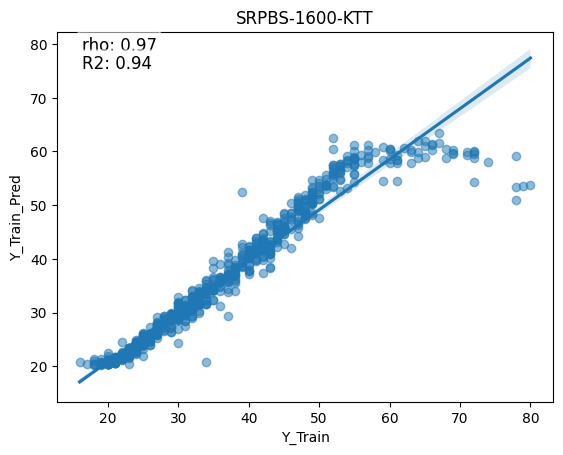

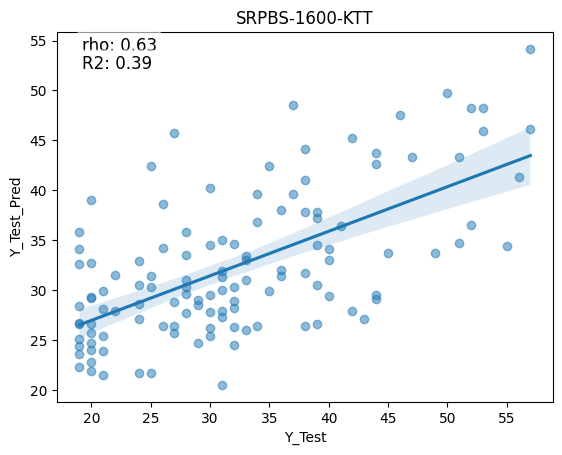

Epoch 0 | Mean Loss 5.088120012283325
Epoch 1 | Mean Loss 3.6396297359466554
Epoch 2 | Mean Loss 3.21343186378479
Epoch 3 | Mean Loss 2.990921001434326
Epoch 4 | Mean Loss 2.8947683429718016
Epoch 5 | Mean Loss 2.85935284614563
Epoch 6 | Mean Loss 2.8551034259796144
Epoch 7 | Mean Loss 2.8542393684387206
Epoch 8 | Mean Loss 2.851633405685425
Epoch 9 | Mean Loss 2.8494200229644777
Epoch 10 | Mean Loss 2.8461258602142334
Epoch 11 | Mean Loss 2.8411285495758056
Epoch 12 | Mean Loss 2.8328413581848144
Epoch 13 | Mean Loss 2.816607074737549
Epoch 14 | Mean Loss 2.7584143924713134
Epoch 15 | Mean Loss 2.609347743988037
Epoch 16 | Mean Loss 2.5951098442077636
Epoch 17 | Mean Loss 2.609512004852295
Epoch 18 | Mean Loss 2.59258526802063
Epoch 19 | Mean Loss 2.5942522144317626
Epoch 20 | Mean Loss 2.5777250862121583
Epoch 21 | Mean Loss 2.589434700012207
Epoch 22 | Mean Loss 2.6016327381134032
Epoch 23 | Mean Loss 2.585351376533508
Epoch 24 | Mean Loss 2.590665111541748
Epoch 25 | Mean Loss 2.58

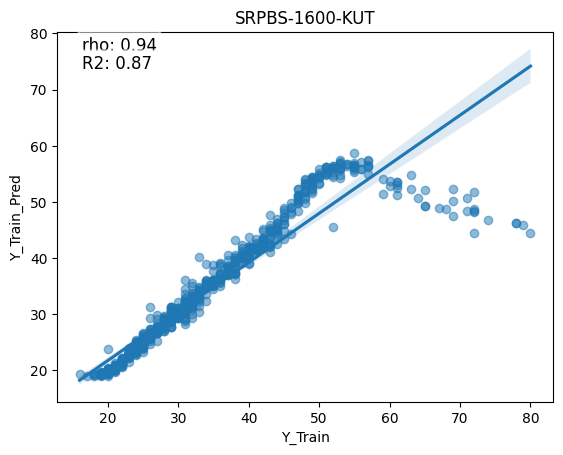

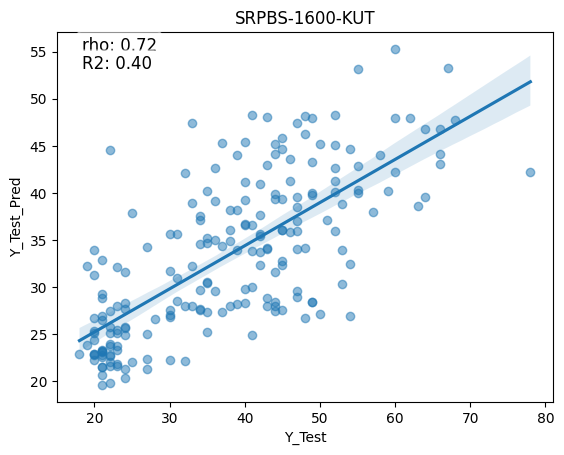

Epoch 0 | Mean Loss 4.199255704879761
Epoch 1 | Mean Loss 3.1158377272742137
Epoch 2 | Mean Loss 2.9109397743429457
Epoch 3 | Mean Loss 2.848453564303262
Epoch 4 | Mean Loss 2.8363614124911174
Epoch 5 | Mean Loss 2.8342219420841763
Epoch 6 | Mean Loss 2.833876371383667
Epoch 7 | Mean Loss 2.8334473030907765
Epoch 8 | Mean Loss 2.833097734621593
Epoch 9 | Mean Loss 2.8327462332589284
Epoch 10 | Mean Loss 2.8330677236829485
Epoch 11 | Mean Loss 2.83230008823531
Epoch 12 | Mean Loss 2.8323756541524614
Epoch 13 | Mean Loss 2.8322025196892873
Epoch 14 | Mean Loss 2.831510020153863
Epoch 15 | Mean Loss 2.8311584847314015
Epoch 16 | Mean Loss 2.8300950484616414
Epoch 17 | Mean Loss 2.829032782997404
Epoch 18 | Mean Loss 2.8271691032818387
Epoch 19 | Mean Loss 2.823526995522635
Epoch 20 | Mean Loss 2.8174010132040297
Epoch 21 | Mean Loss 2.8010763951710294
Epoch 22 | Mean Loss 2.715027775083269
Epoch 23 | Mean Loss 2.606958657503128
Epoch 24 | Mean Loss 2.576662140233176
Epoch 25 | Mean Loss 2

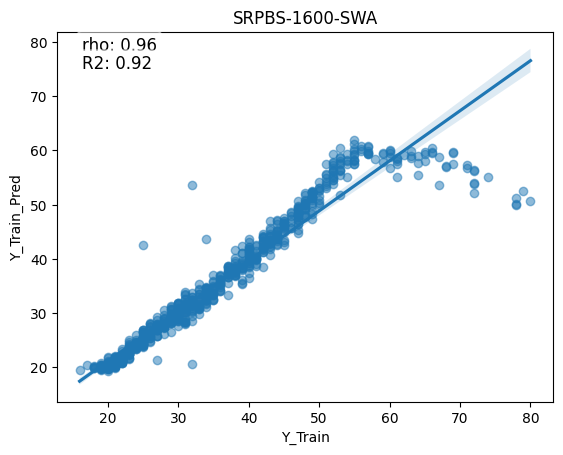

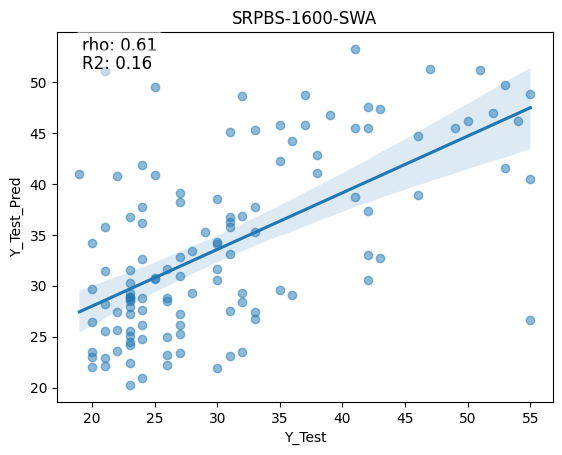

Epoch 0 | Mean Loss 3.6674425983428955
Epoch 1 | Mean Loss 2.852891983985901
Epoch 2 | Mean Loss 2.8490862703323363
Epoch 3 | Mean Loss 2.8469181203842164
Epoch 4 | Mean Loss 2.8446802043914796
Epoch 5 | Mean Loss 2.8392812538146974
Epoch 6 | Mean Loss 2.8161255979537962
Epoch 7 | Mean Loss 2.6376030683517455
Epoch 8 | Mean Loss 2.580922393798828
Epoch 9 | Mean Loss 2.5760597801208496
Epoch 10 | Mean Loss 2.5714520263671874
Epoch 11 | Mean Loss 2.583373303413391
Epoch 12 | Mean Loss 2.5711997747421265
Epoch 13 | Mean Loss 2.5764242792129517
Epoch 14 | Mean Loss 2.571441512107849
Epoch 15 | Mean Loss 2.5707111120224
Epoch 16 | Mean Loss 2.568806824684143
Epoch 17 | Mean Loss 2.572058930397034
Epoch 18 | Mean Loss 2.5609341192245485
Epoch 19 | Mean Loss 2.551532406806946
Epoch 20 | Mean Loss 2.56755108833313
Epoch 21 | Mean Loss 2.553759937286377
Epoch 22 | Mean Loss 2.556347508430481
Epoch 23 | Mean Loss 2.548416805267334
Epoch 24 | Mean Loss 2.563228974342346
Epoch 25 | Mean Loss 2.555

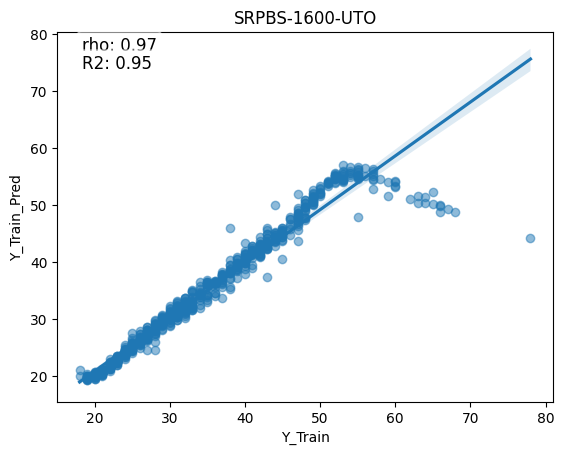

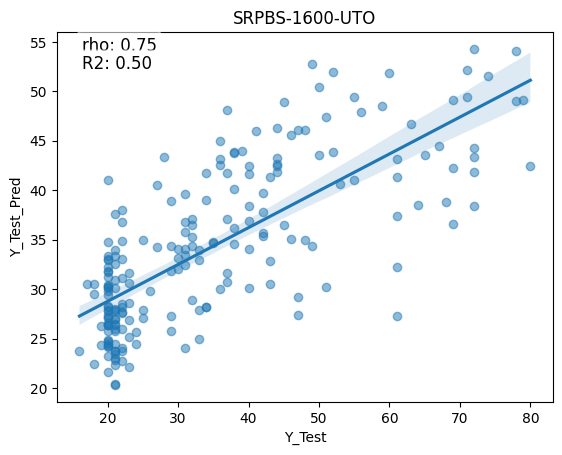

In [11]:
feat_proj = []
targ_proj = []

for site in sites:
    train_dataset = MatData("matrices.npy", "participants.csv", "age", transform = None,test_site = site)
    test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, test_site = site)
    
    standardized_train_dataset = standardize_dataset(train_dataset)
    std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)
    
    standardized_test_dataset = standardize_dataset(test_dataset)
    std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=False)
    
    torch.cuda.empty_cache()
    model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
    criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
    criterion_ptt = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (features, targets) in enumerate(std_train_loader):
            bsz = targets.shape[0]
            n_views = features.shape[1]
            n_feat = features.shape[-1]

            features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
            features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

            optimizer.zero_grad()
            out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])

            out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
            out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]

            loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])

            out_target = torch.split(out_target, [bsz]*n_views, dim=0)
            out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
            loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
            loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
    
    model.eval()
    test_losses = []
    emb_features = [] # saving the embedded features for each batch
    emb_targets = []
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for batch_num, (features, targets) in enumerate(std_test_loader):
            bsz = targets.shape[0]
            n_views = 1
            n_feat = features.shape[-1]

            if len(features.shape) > 2:
                n_views = features.shape[1]
                features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
            features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

            out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   

            out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
            out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]

            loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])

            out_target = torch.split(out_target, [bsz]*n_views, dim=0)
            out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]

            loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
            loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])

            emb_features.append(out_feat[:, 0, :])
            emb_targets.append(out_target[:, 0, :])

            test_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)

        test_losses =np.array(test_losses)
        average_loss = total_loss / total_samples
        print('Mean Test Loss: %6.2f' % (average_loss))
    
    mape_train, r2_train, mape_test, r2_test = compute_age_mae_r2(model, std_train_loader, std_test_loader, device)
    print(f"Site {site}, Train Age MAPE: {mape_train}, Test Age MAPE: {mape_test}.")
    print(f"Site {site}, Train Age R2: {r2_train}, Test Age R2: {r2_test}.")
    X_train, y_train = gather_feats_targets(model, std_train_loader, device)
    X_test, y_test = gather_feats_targets(model, std_test_loader, device)
    
    age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, std_train_loader, std_test_loader, device)

    df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
    df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})

    corr, _ = pearsonr(df_train['Y_Train'], df_train['Y_Train_Pred'])
    corr_text = f'rho: {corr:.2f}'
    r2_text = f'R2: {r2_train:.2f}'
    sns.regplot(x='Y_Train', y='Y_Train_Pred', data=df_train, scatter_kws={'alpha':0.5})
    plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
    plt.annotate(r2_text, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
    plt.title(site)
    plt.show()
    
    corr, _ = pearsonr(df_test['Y_Test'], df_test['Y_Test_Pred'])
    corr_text = f'rho: {corr:.2f}'
    r2_text = f'R2: {r2_test:.2f}'
    sns.regplot(x='Y_Test', y='Y_Test_Pred', data=df_test, scatter_kws={'alpha':0.5})
    plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
    plt.annotate(r2_text, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
    plt.title(site)
    plt.show()
    
    emb_features = torch.row_stack(emb_features).cpu()
    emb_targets = torch.row_stack(emb_targets).cpu()
    emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])
    emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])
    
    emb_features["sub"] = np.arange(1, len(emb_features) +1)
    emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
    emb_features["Type"] = 'Features'
    emb_targets["Type"] = 'Targets'
    emb_features["Site"] = site
    emb_targets["Site"] = site
    
    feat_proj.append(emb_features)
    targ_proj.append(emb_targets)
    del model
    del std_train_loader
    del std_test_loader
    
    

In [20]:
proj = pd.concat([feat_proj, targ_proj])

In [25]:
proj.to_csv("projections.csv")

In [21]:
participants = pd.read_csv("participants.csv")

In [23]:
from utils_v import generate_colors

test_colors = generate_colors(147)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

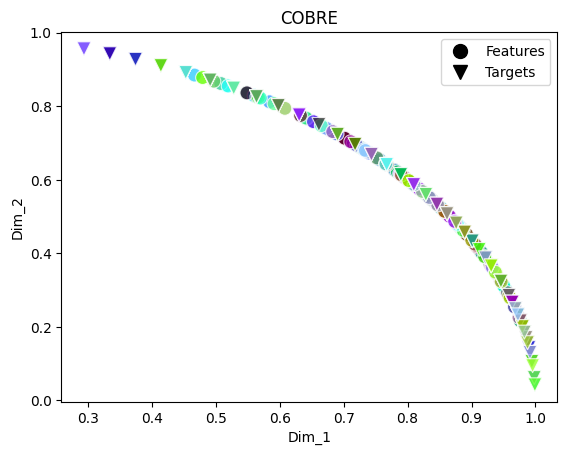

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

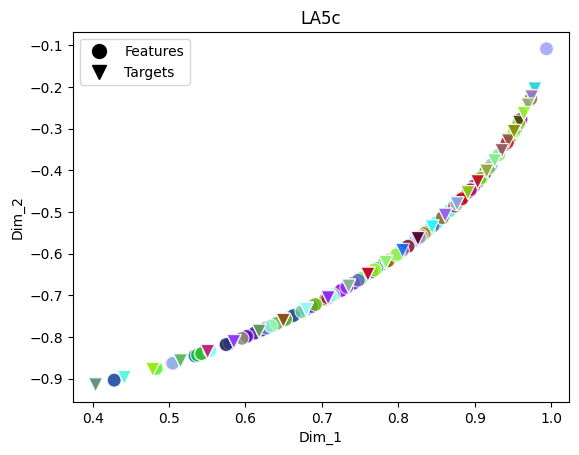

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

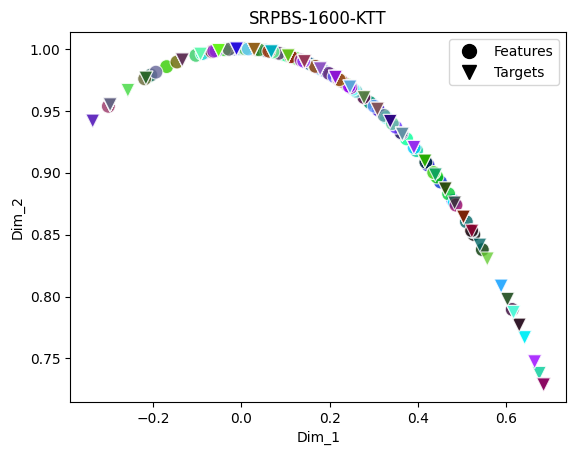

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

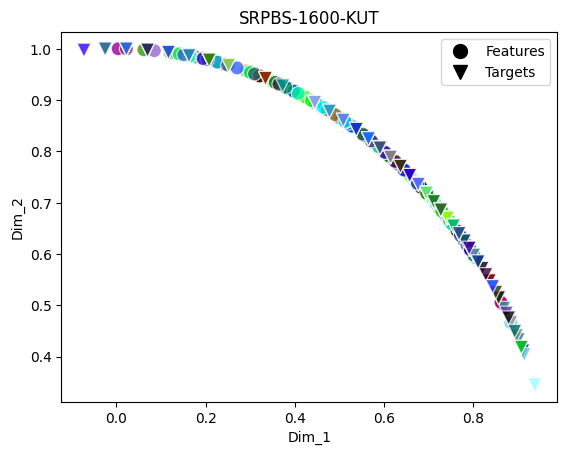

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

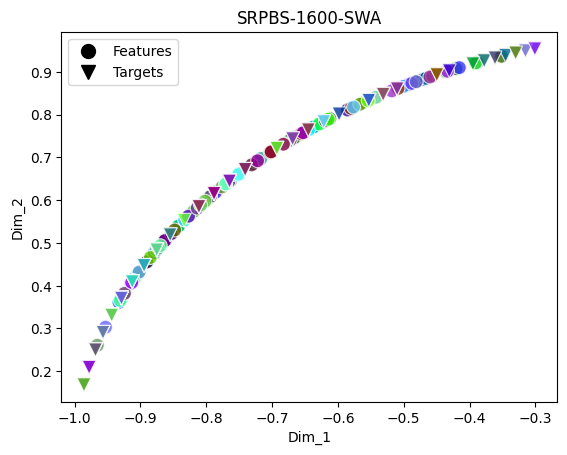

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

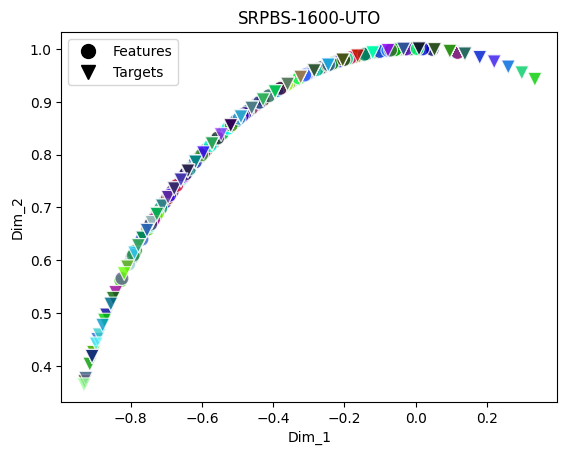

In [24]:
import matplotlib.lines as mlines

for site in sites:
    projections = proj[proj["Site"] == site]
    sns.scatterplot(projections[projections["Type"] == "Features"], x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = test_colors, label='Features')
    sns.scatterplot(projections[projections["Type"] == "Targets"], x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = test_colors, label='Targets')
    feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
    target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')
    plt.legend(handles=[feature_handle, target_handle])
    plt.title(site)
    plt.show()
